In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from lstm_regressor import LSTM, LSTMTrainer
from preprocessing import BasicSmilesTokenizer, PreProcessing
import pandas as pd
import numpy as np

model_config = {
            'epochs': 60,
            'batch_size': 32, 
            'lr': 0.00038419788129315696,
            'dropout': 0.3520475751955372,
            'weight_decay': 1.0528482325186746e-06,
            'num_layers': 2,
            'hidden_dim': 256,
            'embedding_dim': 16
        }

In [2]:
df = pd.read_csv('QM9.csv', index_col=0)
df.head()

,SMILES_1,SMILES_2,INCHI_1,INCHI_2,Property_0
0,OC1COC(=N)C1=O,O[C@H]1CO[C]([NH])C1=O,"InChI=1S/C4H5NO3/c5-4-3(7)2(6)1-8-4/h2,5-6H,1H2","InChI=1S/C4H5NO3/c5-4-3(7)2(6)1-8-4/h2,5-6H,1H...",3.49649
1,CN(C)C(=O)C=O,CN(C)C(=O)C=O,"InChI=1S/C4H7NO2/c1-5(2)4(7)3-6/h3H,1-2H3","InChI=1S/C4H7NO2/c1-5(2)4(7)3-6/h3H,1-2H3",3.92544
2,C1C2CC3N=COCC123,C1[C@H]2C[C@@H]3N=COC[C@]123,InChI=1S/C7H9NO/c1-5-2-7(5)3-9-4-8-6(1)7/h4-6H...,InChI=1S/C7H9NO/c1-5-2-7(5)3-9-4-8-6(1)7/h4-6H...,3.02103
3,OC1C2OC3CC2C13O,O[C@H]1[C@H]2O[C@@H]3C[C@H]2[C@]13O,"InChI=1S/C6H8O3/c7-5-4-2-1-3(9-4)6(2,5)8/h2-5,...","InChI=1S/C6H8O3/c7-5-4-2-1-3(9-4)6(2,5)8/h2-5,...",2.52006
4,OC1C2C(=N)OCC12O,O[C@H]1[C@H]2[C]([NH])OC[C@@]12O,"InChI=1S/C5H7NO3/c6-4-2-3(7)5(2,8)1-9-4/h2-3,6...","InChI=1S/C5H7NO3/c6-4-2-3(7)5(2,8)1-9-4/h2-3,6...",2.48587


In [3]:
vocab = [
            '#', '(', ')', '-', '/', '1', '2', '3', '4', '5', '6', '=', 'Br', 'C', 'Cl',
            'F', 'I', 'In', 'N', 'O', 'P', 'S', '[17O]', '[AlH-]', '[AlH2-]', '[AlH3-]',
            '[AsH3-]', '[BH-]', '[BH2-]', '[BH3-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]',
            '[C@]', '[CH-]', '[CH2-]', '[CH2]', '[CH]', '[C]', '[GaH-]', '[GaH2-]', '[GaH3-]',
            '[InH-]', '[InH2-]', '[InH3-]', '[N+]', '[N-]', '[N@+]', '[N@@+]', '[N@@]', '[N@]',
            '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[NH]', '[N]', '[NbH3-]', '[O+]', '[O-]', '[O]',
            '[PH+]', '[PH3-]', '[PH4-]', '[S+]', '[SbH3-]', '[Si]', '[TaH3-]', '[c-]', '[cH-]',
            '[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '\\', 'c', 'n', 'o', ''
        ]

prep = PreProcessing(vocab=vocab)
data_info = prep.prepare_data_from_df(df, smiles_col='SMILES_1', target_col='Property_0')

In [4]:
next(iter(data_info['train_loader']))

(tensor([[13, 13, 13,  5, 18, 13,  1, 11, 19,  2, 13,  5, 13, 19, 80, 80, 80, 80],
         [13, 13,  5,  1, 13,  2, 13,  6, 19, 13,  6, 13,  6, 19, 13,  5,  6, 80],
         [13, 19, 13, 13,  5, 11, 13, 13,  1, 18,  2, 11, 18, 19,  5, 80, 80, 80],
         [19, 13, 13,  5, 13, 13,  6, 13, 13,  7, 13,  6, 13,  5,  7, 80, 80, 80],
         [13, 18, 11, 13, 19, 13,  5, 11, 13, 19, 18, 11, 18,  5, 80, 80, 80, 80],
         [13, 13,  5, 11, 13, 13,  6, 18, 13,  6, 13,  5,  5, 13, 19,  5, 80, 80],
         [13,  5, 13, 13,  5, 13,  5, 13,  6, 13, 19, 13,  5,  6, 80, 80, 80, 80],
         [13,  0, 13, 13,  5,  6, 13,  7, 13, 11, 13, 13,  5, 13, 18,  6,  7, 80],
         [13, 13, 19, 13,  5, 13, 19, 13,  5,  5, 13, 13,  5, 80, 80, 80, 80, 80],
         [19, 13, 13,  5, 13, 13, 11, 13, 13,  1, 11, 19,  2, 13,  5, 80, 80, 80],
         [13, 19, 13, 13,  5, 11, 13, 13, 13,  1, 13,  2, 13,  5, 80, 80, 80, 80],
         [19, 11, 13,  5, 13, 18, 13,  1, 11, 19,  2, 18,  5, 80, 80, 80, 80, 80],
    

In [5]:
model = LSTM(
                vocab_size=data_info['vocab_size'],
                embedding_dim=model_config['embedding_dim'],
                hidden_dim=model_config['hidden_dim'],
                num_layers=model_config['num_layers'],
                padding_idx=data_info['padding_idx'],
                dropout=model_config['dropout']
            )

In [6]:
trainer = LSTMTrainer(model=model)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(
                model.parameters(),
                lr=model_config['lr'],
                weight_decay=model_config['weight_decay']
            )

train_losses, val_losses = trainer.train_model(
                train_loader=data_info['train_loader'],
                val_loader=data_info['val_loader'],
                num_epochs=model_config['epochs'],
                criterion=criterion,
                optimizer=optimizer
            )

eval_results = trainer.evaluate_model(
                test_dataloader=data_info['test_loader'],
                criterion=criterion,
                scaler=data_info['scaler']
            )

Model is running on: GPU
Epoch 1/60 — Train Loss: 5.6678 — Val Loss: 2.1201


KeyboardInterrupt: 

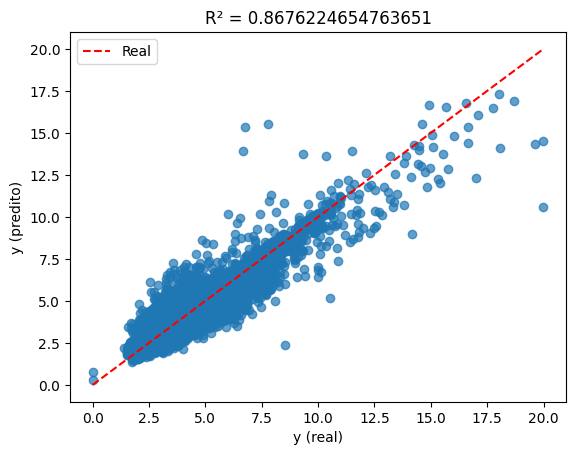

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_true = eval_results['y_true']
y_pred = eval_results['y_pred']

r2 = r2_score(y_true, y_pred)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Real')
plt.scatter(y_true, y_pred, alpha=0.7)
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.title(f"R² = {r2}")
plt.legend()
plt.show()

In [ ]:
y_true

array([3.7505898, 3.17089  , 2.41014  , ..., 3.5369098, 4.55498  ,
       2.07447  ], dtype=float32)

In [ ]:
y_pred

array([3.73501  , 3.0878701, 2.0893967, ..., 3.1047435, 4.7244434,
       2.1567898], dtype=float32)

In [ ]:
# Erro de teste
criterion = torch.nn.MSELoss(reduction='mean')

print("Erro de teste: ", criterion(torch.tensor(y_true), torch.tensor(y_pred)).item())

Erro de teste:  0.23034943640232086


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE real:", mean_squared_error(y_true, y_pred))
print("MAE real:", mean_absolute_error(y_true, y_pred))

MSE real: 0.23034945
MAE real: 0.32994068
